In [1]:
!pip install transformers datasets emoji scikit-learn torch

In [7]:
import re
import torch
import emoji
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE



In [8]:
# Define text cleaning function
def clean_text(text):
    text = text.encode('latin-1', errors='ignore').decode('utf-8', errors='ignore')  
    text = emoji.demojize(text)  
    text = text.lower()  
    text = re.sub(r"@\w+", "", text)  
    text = re.sub(r"http\S+|www\S+", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    return text

# Load dataset
df = pd.read_csv("/kaggle/input/twitter-racism/twitter_racism_dataset.csv")

# Select relevant columns
df = df[["Text", "oh_label"]]

# Apply text cleaning
df["Text"] = df["Text"].apply(clean_text)

# Convert labels if needed
df["oh_label"] = df["oh_label"].astype(int)  # Ensure labels are integers


In [9]:
df.head(5)

,Text,oh_label
0,muslim mob violence against hindus in banglade...,1
1,,0
2,islamophobia is like the idea of naziphobia. i...,1
3,"finally i'm all caught up, and that sudden dea...",0
4,*hugs*,0


oh_label
0    11501
1     1970
Name: count, dtype: int64


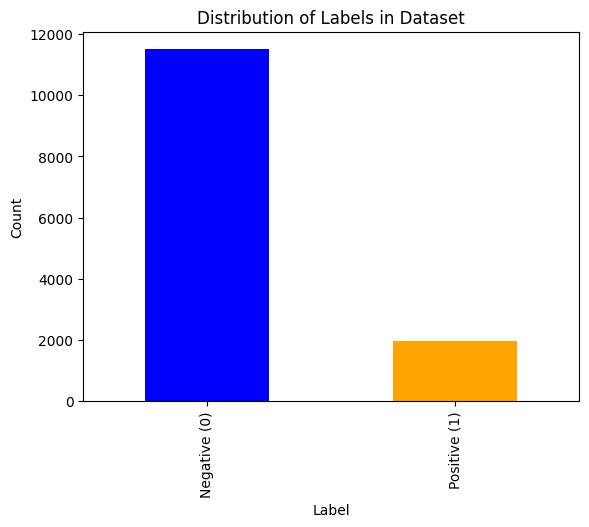

In [10]:
print(df["oh_label"].value_counts())
import matplotlib.pyplot as plt

df["oh_label"].value_counts().plot(kind="bar", color=["blue", "orange"])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels in Dataset")
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"])
plt.show()


In [11]:
# Load tokenizer and model
model_checkpoint = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint)


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Function to get embeddings from RoBERTa
def get_roberta_embeddings(texts, batch_size=16):
    model.eval()  # Set model to evaluation mode
    embeddings = []

    with torch.no_grad():  # No gradient calculation for faster inference
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i : i + batch_size]
            
            # Tokenize batch
            encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
            
            # Forward pass through RoBERTa
            outputs = model(**encoded_inputs)
            
            # Extract the [CLS] token embeddings (pooled output)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            embeddings.extend(cls_embeddings)

    return np.array(embeddings)

# Get embeddings for the dataset
X = get_roberta_embeddings(df["Text"].tolist())

# Labels
y = df["oh_label"].values

print("Embeddings Shape:", X.shape)  # Should be (num_samples, 768)


Embeddings Shape: (13471, 768)


In [13]:
X = get_roberta_embeddings(df["Text"].tolist())
y = df["oh_label"].values

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Apply SMOTE ONLY to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [16]:
print("Class distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

Class distribution after SMOTE:
0    9206
1    9206
Name: count, dtype: int64


In [17]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_res, y_train_res)
y_pred = log_reg.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9009276437847866
F1 Score: 0.9076734784980012
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94      2295
           1       0.62      0.88      0.72       400

    accuracy                           0.90      2695
   macro avg       0.80      0.89      0.83      2695
weighted avg       0.92      0.90      0.91      2695



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",  # Changed from multi-class
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.6,
    colsample_bytree=1.0,
    random_state=42
)
xgb_model.fit(X_train_res, y_train_res)
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9146567717996289
F1 Score: 0.9186405162430925
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      2295
           1       0.67      0.84      0.75       400

    accuracy                           0.91      2695
   macro avg       0.82      0.89      0.85      2695
weighted avg       0.93      0.91      0.92      2695



In [19]:
# Modified Hyperparameter Tuning
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_lambda": [0, 1, 10],
    "reg_alpha": [0, 1, 10],
}

Hyperparameter

In [20]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

random_search = RandomizedSearchCV(
    xgb.XGBClassifier(
        objective="binary:logistic",  # Fixed objective
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    ),
    param_distributions=param_grid,
    n_iter=20,
    scoring="f1_weighted",
    cv=3,
    verbose=2,
    n_jobs=-1
)
random_search.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 6, 9],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 1, 10],
                                        'reg_lambda': [0, 1, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='f1_weighted', verbose=2)

In [25]:
import joblib
from transformers import AutoTokenizer, AutoModel

# Save the complete pipeline components
joblib.dump({
    'xgb_model': xgb_model,
    'roberta_tokenizer': tokenizer,
    'roberta_model': model,
    'clean_text_func': clean_text
}, 'racism_detection_pipeline.pkl')

['racism_detection_pipeline.pkl']

In [26]:
import shutil

shutil.make_archive("/kaggle/working/racism_detection_pipeline", 'zip', "/kaggle/working", "racism_detection_pipeline.pkl")


'/kaggle/working/racism_detection_pipeline.zip'

Second method

In [62]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

# Define your text cleaning function
def clean_text(text):
    text = text.encode('latin-1', errors='ignore').decode('utf-8', errors='ignore')
    text = emoji.demojize(text)  
    text = text.lower()  
    text = re.sub(r"@\w+", "", text)  
    text = re.sub(r"http\S+|www\S+", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    return text

# Load dataset (Replace with your dataset file)
df = pd.read_csv("/kaggle/input/twitter-racism/twitter_racism_dataset.csv")
df = df[["Text", "oh_label"]]  # Select relevant columns
df = df.rename(columns={"Text": "text", "oh_label": "label"})  # Rename for consistency

# Clean text
df["text"] = df["text"].apply(clean_text)

# Convert labels if necessary (assuming 0: racism, 1: non-racism)
df["label"] = df["label"].astype(int)

# Split into train/test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert to Hugging Face dataset
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

# Load the tokenizer and model
model_checkpoint = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Tokenize datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove original text column
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

# Load the model with num_labels=2 for binary classification
# Load the model with num_labels=2 for binary classification and ignore size mismatch
model = RobertaForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=2,
    ignore_mismatched_sizes=True  # Add this parameter
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"  # Disable WandB reporting
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,  # Attach the metric function
)
# Disable WandB logging
os.environ["WANDB_DISABLED"] = "true"  # Disable WandB logging

# Train the model
trainer.train()

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred  # Unpack the tuple directly
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Map:   0%|          | 0/10776 [00:00<?, ? examples/s]

Map:   0%|          | 0/2695 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.228300,0.161946,0.936920,0.937490
2,0.119800,0.209166,0.933581,0.934779
3,0.098600,0.358027,0.927644,0.925401
4,0.055500,0.415408,0.925046,0.925941
5,0.045400,0.462896,0.924304,0.924988
